# Previsão deSéries Temporais FInanceiras com MLP + LSTM + GA
Contexto:<br>
Desenvolveremos a previsão de preços mediante uma abordagem hibrida, combinando algoritmos de aprendizado profundo e multilayer perceptron. Evaluaremos cada um dos resultados para concluir em qual dos cenários as previsões apresentam maior precisão.<br><br>
Bases: <br> 
No estudo, consideramos dados de movimentações da Bolsa Brasileira, no período desde 2018-01-01 até 2023-06-30. Totalizando cinco (05) anos, mais os restantes seis (06) meses do 2023.<br><br>

Algoritmos:<br>
Neste ponto aplicaremos: <br>
* Multilayer perceptron (MLP).
* Aprendizagem profunda Long Short Term Memory (LSTM). 
* Modelo híbrido que combina MLP e LSTM + Algoritmo Genetico. 


### Importação dos Dados

### Bibliotecas

In [39]:
import warnings
warnings.filterwarnings("ignore")

import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import yfinance as yf 
#import mlrose_hiive 
import math
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as split_ML
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from pmdarima import arima
from pmdarima import datasets
from pmdarima import utils

from sklearn.model_selection import train_test_split as split_ML
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as MSE

import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.stattools import acf
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#import jupyterthemes as jt 
#from jupyterthemes import jtplot  
#jtplot.style(theme='oceans16')

In [40]:
def plot_histograms(df):
    num_columns = len(df.columns)
    fig, axs = plt.subplots(num_columns, 1, figsize=(14, 20))
    for i in range(num_columns):
        sns.histplot(df[df.columns[i]], kde=True, ax=axs[i])
        axs[i].set_title(df.columns[i])
            

def plot_boxplots(df):
    num_columns = len(df.columns)
    
    fig, axs = plt.subplots(num_columns, 1, figsize=(14, 20))
    
    for i in range(num_columns):
        sns.boxplot(x=df[df.columns[i]], ax=axs[i])
        axs[i].set_title(df.columns[i])

def normalize_columns(df):
    df_normalized = df.copy()
    
    for column in df_normalized.columns:
        df_normalized[column] = df_normalized[column] / df_normalized[column][0]
    
    return df_normalized

def plot_stock_price_history(df_normalized, title='Histórico de preço de Ações'):
    figura = px.line(title=title)
    
    for column in df_normalized.columns:
        figura.add_scatter(x=df_normalized.index, y=df_normalized[column], name=column)
    
    figura.show()


### Importando Dados

#### Ações Vale3

In [41]:
ticker_symbols = ['VALE3.SA'] 
start_date = '2018-01-01'
end_date = '2023-06-30'
df_vale = yf.download(ticker_symbols, start=start_date, end=end_date)



[*********************100%%**********************]  1 of 1 completed


In [42]:
df_vale.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-23,66.000000,66.099998,65.300003,65.900002,63.341267,23510900
2023-06-26,65.559998,66.300003,65.320000,66.040001,63.475834,15030400
2023-06-27,66.900002,67.279999,66.449997,66.830002,64.235161,22737400
2023-06-28,66.779999,66.820000,64.720001,64.720001,62.207088,37628600
2023-06-29,64.720001,65.930000,64.349998,65.510002,62.966415,24841800


In [43]:
# Mentando apenas a coluna 'Close' e renomeie-a para 'BOVA11'
df_vale = df_vale[['Close']].rename(columns={'Close': 'VALE3'})
df_vale.head()

,VALE3
Date,
2018-01-02,41.720001
2018-01-03,41.470001
2018-01-04,41.639999
2018-01-05,42.290001
2018-01-08,43.230000


### Distribuição dos dados

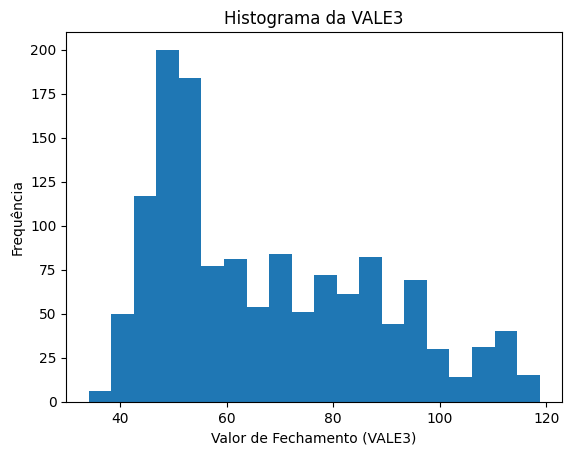

In [44]:
import matplotlib.pyplot as plt

plt.hist(df_vale['VALE3'], bins=20)  # Plotando um histograma com 20 bins
plt.xlabel('Valor de Fechamento (VALE3)')
plt.ylabel('Frequência')
plt.title('Histograma da VALE3')
plt.show()

In [45]:
#!pip install seaborn


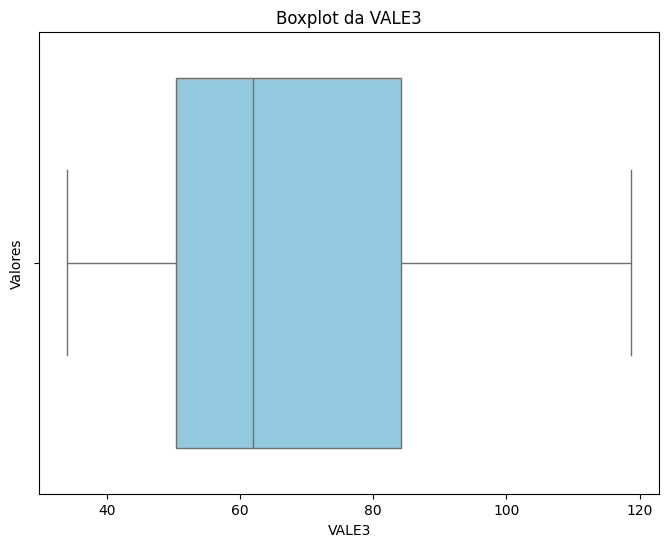

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  
sns.boxplot(x='VALE3', data=df_vale, color='skyblue')  

plt.xlabel('VALE3')
plt.ylabel('Valores')
plt.title('Boxplot da VALE3')

plt.show()

### Gráficos das Ações

<Axes: title={'center': 'Histórico do preço de Ações - Vale3'}, xlabel='Date'>

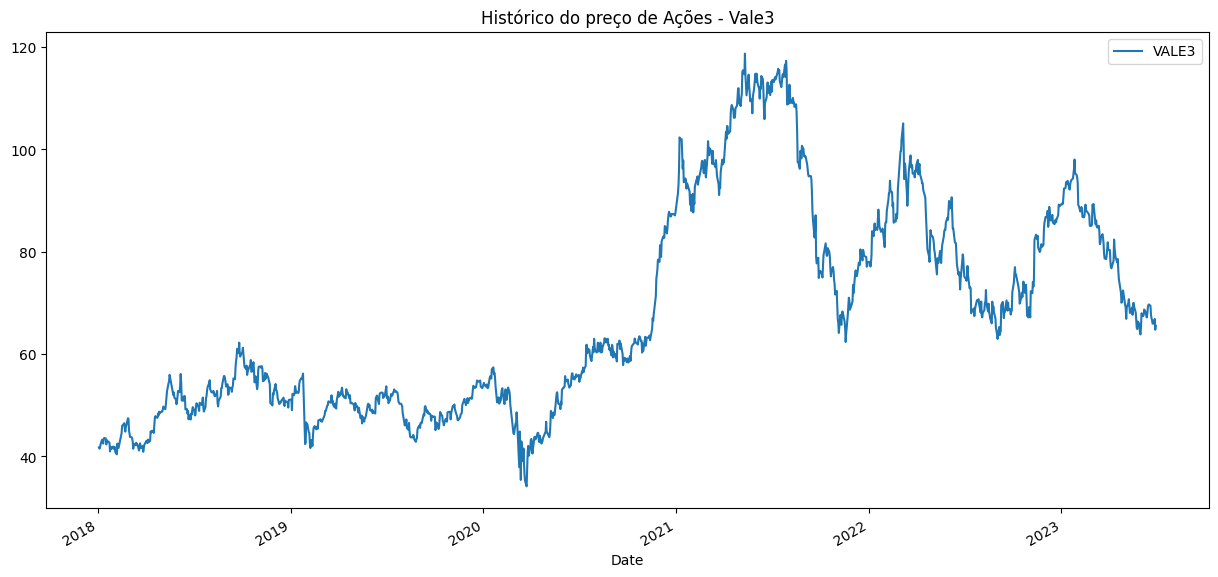

In [47]:
df_vale.plot(figsize=(15,7), title='Histórico do preço de Ações - Vale3')

### Gráficos das Ações Normalizadas

In [48]:
#!pip install pmdarima 

In [49]:
df_mlp_vale3 = df_vale.copy()
df_mlp_vale3.tail()

,VALE3
Date,
2023-06-23,65.900002
2023-06-26,66.040001
2023-06-27,66.830002
2023-06-28,64.720001
2023-06-29,65.510002


<Axes: title={'center': 'Ações VALE3'}, xlabel='Date'>

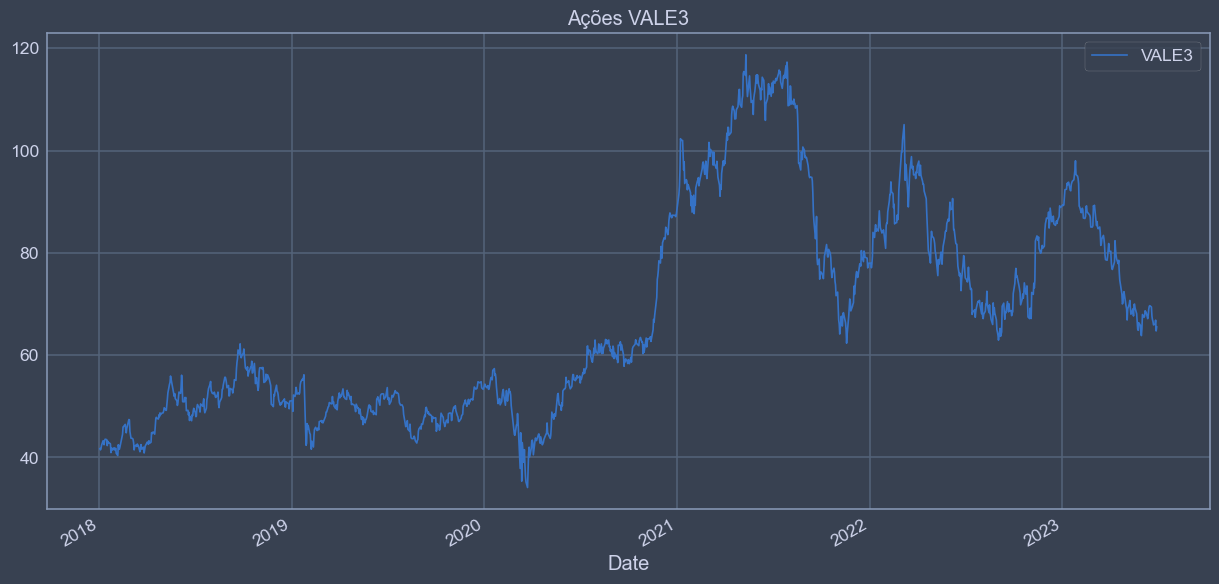

In [12]:
df_mlp_vale3.plot(figsize=(15,7), title='Ações VALE3')

Onservamos a decomposição da série

Text(0.5, 1.0, 'Seasonal Decomposition of Sales Dataset')

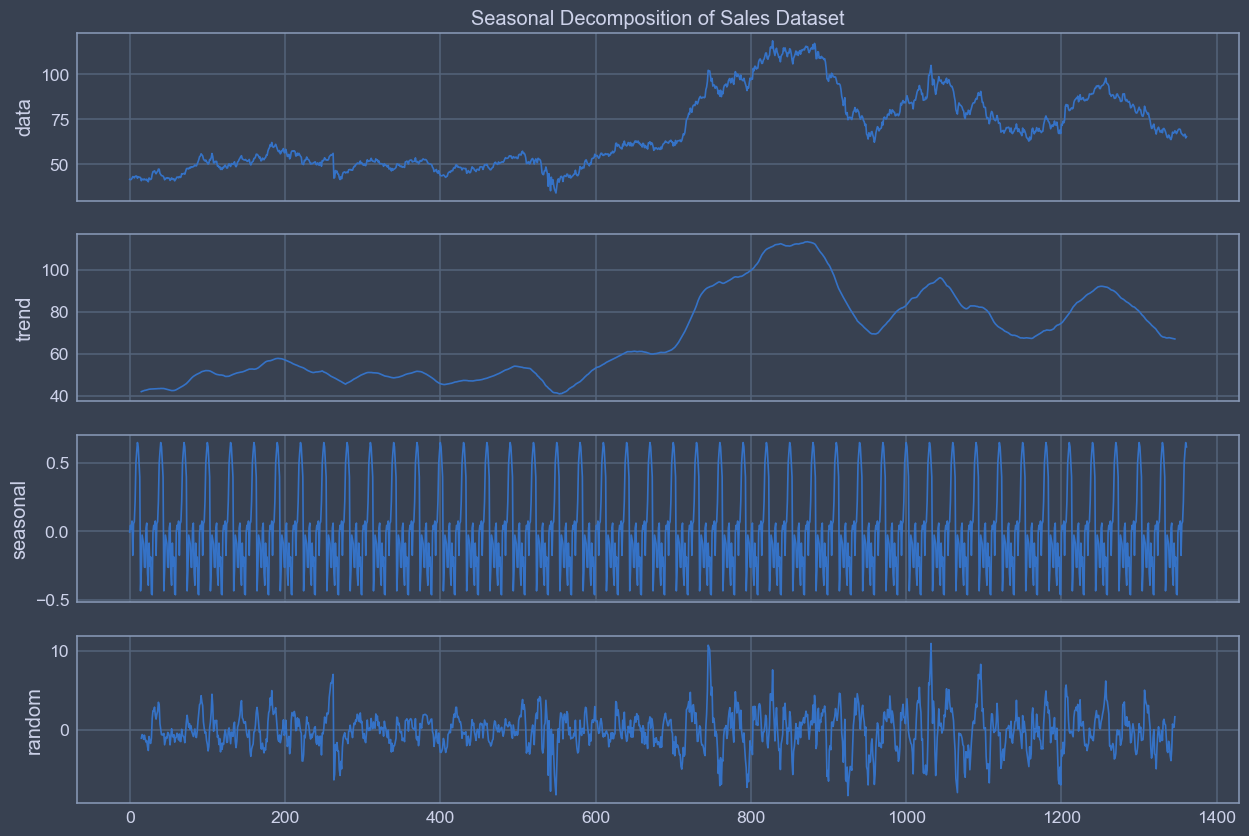

In [13]:
figure_kwargs = {'figsize': (15, 10)}  #
decomposed = arima.decompose(df_mlp_vale3.values.reshape(-1),
                             'additive', m=30)

axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs,
                             show=False)
axes[0].set_title( "Seasonal Decomposition of Sales Dataset")

In [50]:
m = 5 # define os passos a 20 pontos temporais - mudarei pra 5 (01 semana)
test_size=15 # Para ter a mesma quantidade que no LSTM era 60, deixei em 15 (3 semanas)
y = df_mlp_vale3.values
train_len = len(y) - test_size 

In [51]:
from sklearn.preprocessing import RobustScaler
_scaler = RobustScaler()
_scaler.fit(y[0:train_len].reshape(-1, 1))
serie_normalized = _scaler.transform(y.reshape(-1, 1)).flatten()

In [52]:
from pmdarima.model_selection import train_test_split

y_train, y_test = train_test_split(serie_normalized, train_size=train_len)
print("Tamanho dos dados de treinamento:", len(y_train))
print("Tamanho dos dados de teste:", len(y_test))

Tamanho dos dados de treinamento: 1347
Tamanho dos dados de teste: 15


In [53]:
def gerar_janelas(tam_janela, serie):
  # serie: vetor do tipo numpy ou lista
  tam_serie = len(serie)
  tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela

  janela = list(serie[0:0+tam_janela])
  janelas_np = np.array(np.transpose(janela))

  for i in range(1, tam_serie-tam_janela):
    janela = list(serie[i:i+tam_janela])
    j_np = np.array(np.transpose(janela))

    janelas_np = np.vstack((janelas_np, j_np))
  return janelas_np

In [54]:
def select_lag_acf(serie, max_lag):
  x = serie[0: max_lag+1]

  acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False)

  limiar_superior = confint[:, 1] - acf_x
  limiar_inferior = confint[:, 0] - acf_x

  lags_selecionados = []
  for i in range(1, max_lag+1):
    if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
      lags_selecionados.append(i-1)

  if len(lags_selecionados)==0:
    print('NENHUM LAG POR ACF')
    lags_selecionados = [i for i in range(max_lag)]

  lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
  print('LAGS', lags_selecionados)

  return lags_selecionados

In [55]:
df_mlp_vale3 = df_mlp_vale3.rename(columns={'VALE3': 'target'})

In [56]:
lag_sel = select_lag_acf(df_mlp_vale3.target, 15) 

LAGS [14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


In [57]:
def train_test_val_split(serie):
  x_date = serie[:, 0:-1]
  y_date = serie[:, -1]

  train_size = np.fix(len(serie)*0.70).astype(int)

  test_size  = np.fix(len(serie)*0.25).astype(int) # dados de treino
  val_size = len(serie) - train_size - test_size #dados de validação

  x_train = x_date[0:train_size,:]
  y_train = y_date[0:train_size]
  print("Particao de Treinamento:", 0, train_size)

  x_val = x_date[train_size:(train_size+test_size),:]
  y_val = y_date[train_size:(train_size+test_size)]
  print("Particao de Validação:", train_size, (train_size+test_size))

  x_test = x_date[(train_size+test_size):-1,:]
  y_test = y_date[(train_size+test_size):-1]
  print("Particao de Teste:", (train_size+val_size), len(y_date))

  return x_train, y_train, x_test, y_test, x_val, y_val 

In [58]:
max_janelas = lag_sel[0]
janelas_teste = gerar_janelas(max_janelas, df_mlp_vale3.target)
x_train, y_train, x_test, y_test, x_val, y_val = train_test_val_split(janelas_teste)
#Particao de Treinamento: 0 646
#Particao de Validação: 646 969
#Particao de Teste: 969 1292

Particao de Treinamento: 0 942
Particao de Validação: 942 1278
Particao de Teste: 1011 1347


### Previsão de Preços com MLP

In [24]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec):
    neuronios =  [1, 10, 50, 100]#, 150, 200]    #[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 170, 200]
    func_activation =  ['relu']#,'tanh']
    alg_treinamento = ['adam']#,'lbfgs', 'sgd' ]
    #lbfgs, lento em comparação com sgd, otimizador que usa aproximação de 2da ordem
    #gsd otimizador estocástico, atualiza os pesos do modelo baseado no gradiente.
    #adam, combina sgd com ajuste de taxa de aprendizado adaptativo
    max_iteracoes = [100]#, 1000]
    learning_rate = [ 'adaptive']#,'constant', 'invscaling'] #ficarei com adaptative
    # adaptative, o algoritmo ajusta dinamicamente a taxa de aprendizado durante o treinamento
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(max_iteracoes)):
                    for n in range(0,len(learning_rate)):
                        for qtd_lag in range(1, len(x_train[0]+1)): #variar a qtd de pontos utilizados na janela

                            print('QTD de Lags:', qtd_lag, 'Qtd de Neuronios' ,neuronios[i], 'Func. Act', func_activation[j])

                            for e in range(0,num_exec):
                                mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], activation=func_activation[j], 
                                                   solver=alg_treinamento[l], max_iter = max_iteracoes[m], 
                                                   learning_rate= learning_rate[n])

                                mlp.fit(x_train[:,-qtd_lag:], y_train)
                                predict_validation = mlp.predict(x_val[:,-qtd_lag:])
                                mse = MSE(y_val, predict_validation)

                                if mse < best_result:
                                    best_result = mse
                                    print('Melhor MSE:', best_result)
                                    select_model = mlp
                                    qtd_lags_sel = qtd_lag

    print('QTD de Lags:', qtd_lags_sel, 'Func. Act', func_activation[j])

    return select_model, qtd_lags_sel

In [25]:
modelo_MLP, lag_sel = treinar_mlp(x_train, y_train, x_val, y_val, 2) 

QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
Melhor MSE: 494.70149606362094
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
Melhor MSE: 6.880228888563993
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
Melhor MSE: 3.542901986299899
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd

In [26]:
print('Melhor configuração do MLP:', modelo_MLP)
print('Melhor lag:', lag_sel) 

Melhor configuração do MLP: MLPRegressor(hidden_layer_sizes=100, learning_rate='adaptive', max_iter=100)
Melhor lag: 1


##### Teste

In [27]:
previsoes_mlp_treino = modelo_MLP.predict(x_train[:, -lag_sel:])
previsoes_mlp_teste = modelo_MLP.predict(x_test[:, -lag_sel:])
previsoes_mlp_val = modelo_MLP.predict(x_val[:, -lag_sel:])

In [28]:
print('MSE:', mse(y_val, previsoes_mlp_val))
print('MAPE:', mape(y_val, previsoes_mlp_val)*100)

#MSE: 4.572328104161885   anterior com 1000 iteracoes
#MAPE: 1.7706028663892228

#MSE: 4.6073148966346995  antes de la última
#MAPE: 1.7762101499136742

MSE: 3.479298975019828
MAPE: 1.734480012236132


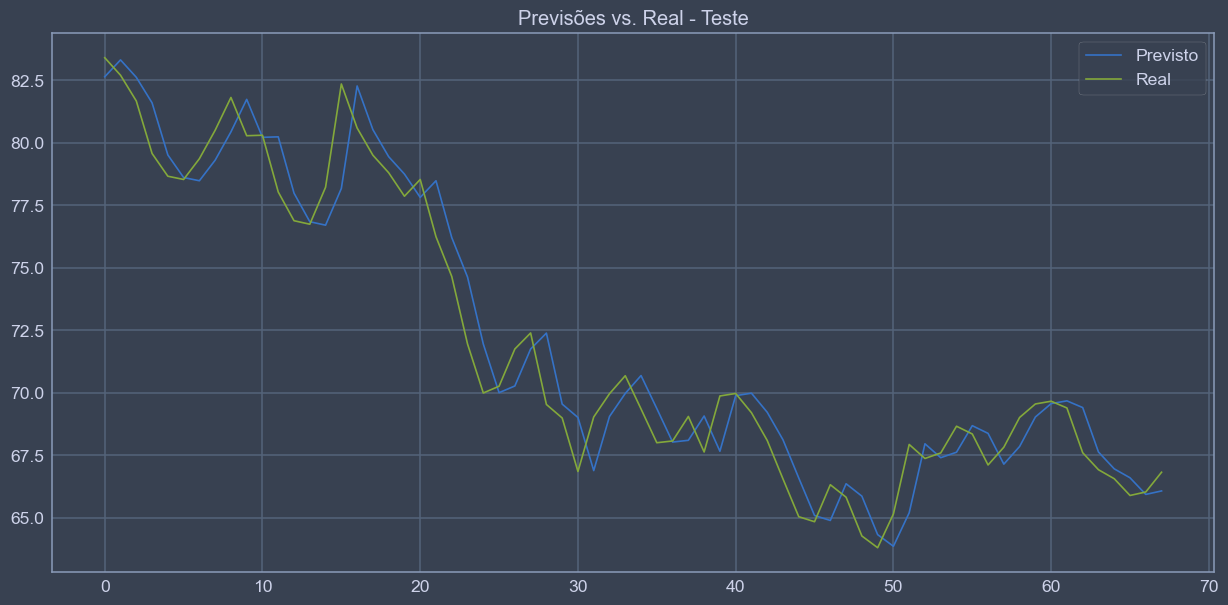

In [29]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(previsoes_mlp_teste, label = 'Previsto')
plt.plot(y_test, label='Real')
plt.title('Previsões vs. Real - Teste')
plt.legend(loc='best')
plt.show()

In [79]:
print('MSE:', mse(y_val, previsoes_mlp_val))
print('MAPE:', mape(y_val, previsoes_mlp_val)*100)

#MSE: 4.572328104161885   anterior com 1000 iteracoes
#MAPE: 1.7706028663892228

#MSE: 4.6073148966346995  antes de la última
#MAPE: 1.7762101499136742

MSE: 3.4488338092431094
MAPE: 1.7028641040668897


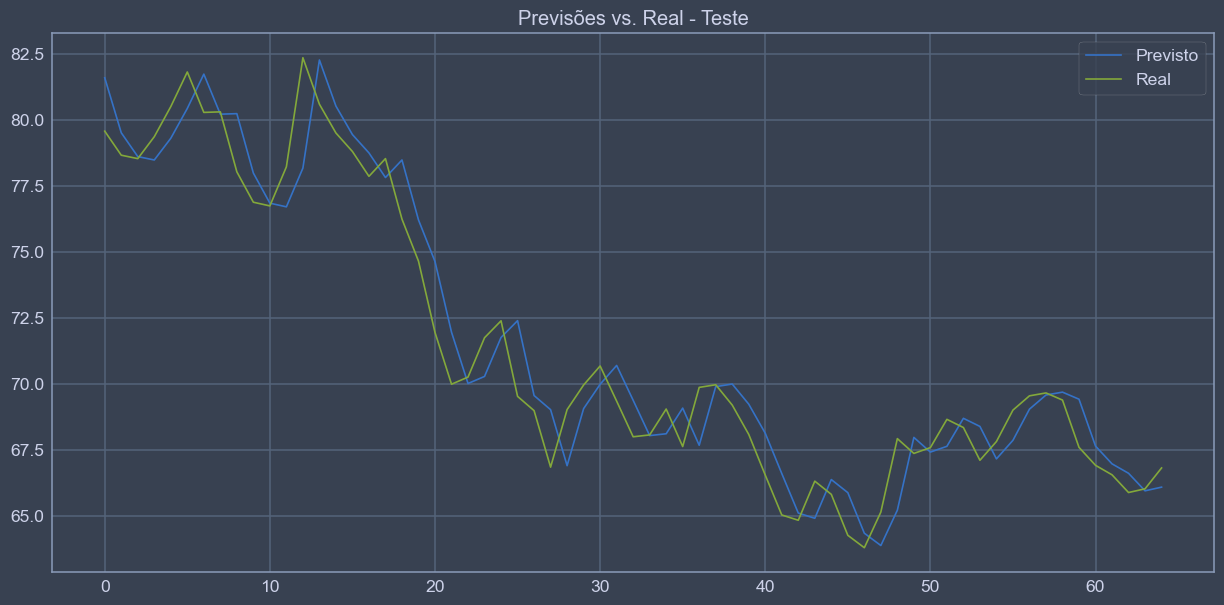

In [80]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(previsoes_mlp_teste, label = 'Previsto')
plt.plot(y_test, label='Real')
plt.title('Previsões vs. Real - Teste')
plt.legend(loc='best')
plt.show()

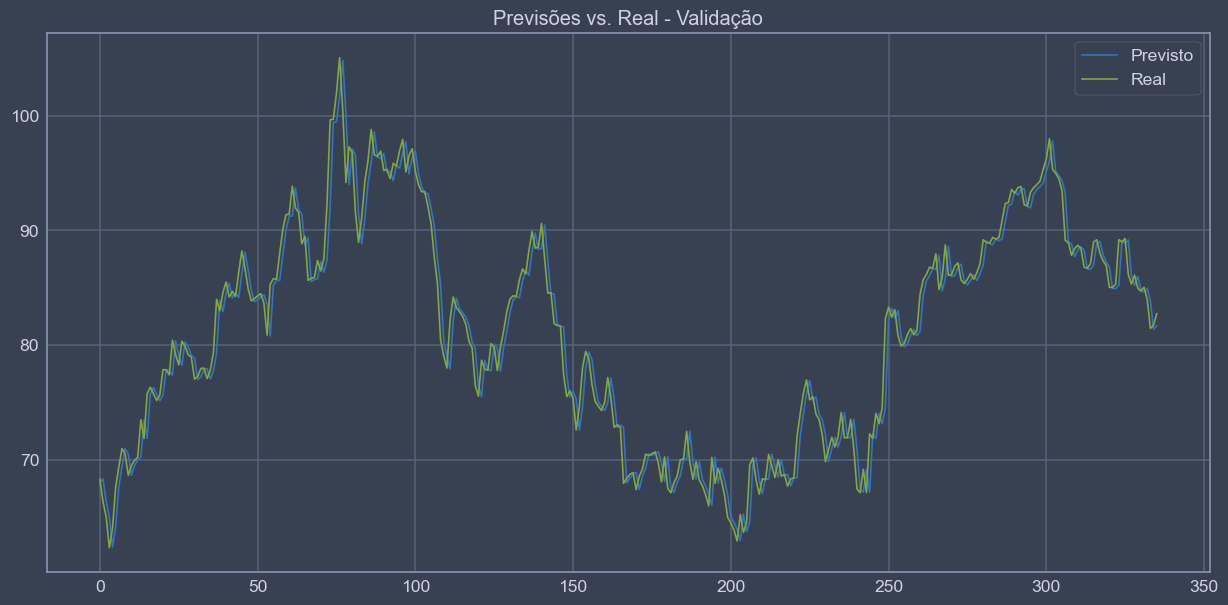

In [30]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(previsoes_mlp_val, label = 'Previsto')
plt.plot(y_val, label='Real')
plt.title('Previsões vs. Real - Validação')
plt.legend(loc='best')
plt.show()

### Previsão de Preços com LSTM 

In [36]:
print(len(x_train))
print(len(x_val))
print(len(x_test))


946
338
68


In [37]:

x_train_lstm = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_val_lstm = x_val.reshape(x_val.shape[0], 1, x_val.shape[1])
x_test_lstm = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

In [38]:
def build_lstm_model(input_shape, output_dim):
    model = Sequential()
    model.add(LSTM(500, input_shape=input_shape, activation='relu'))      
    model.add(Dense(output_dim))  
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_input_shape = (x_train_lstm.shape[1], x_train_lstm.shape[2])
lstm_output_dim = 1  # Since you're doing regression.

lstm_model = build_lstm_model(lstm_input_shape, lstm_output_dim)
lstm_model.fit(x_train_lstm, y_train, epochs=500, batch_size=32, validation_data=(x_val_lstm, y_val))


Epoch 1/500
30/30 [==============================] - 2s 33ms/step - loss: 747.5975 - val_loss: 37.0687
Epoch 2/500
30/30 [==============================] - 1s 29ms/step - loss: 12.2491 - val_loss: 15.6241
Epoch 3/500
30/30 [==============================] - 1s 27ms/step - loss: 8.7386 - val_loss: 13.9601
Epoch 4/500
30/30 [==============================] - 1s 28ms/step - loss: 8.2169 - val_loss: 14.0473
Epoch 5/500
30/30 [==============================] - 1s 28ms/step - loss: 8.3011 - val_loss: 13.9506
Epoch 6/500
30/30 [==============================] - 1s 27ms/step - loss: 8.7521 - val_loss: 13.6958
Epoch 7/500
30/30 [==============================] - 1s 28ms/step - loss: 8.0199 - val_loss: 13.3760
Epoch 8/500
30/30 [==============================] - 1s 27ms/step - loss: 7.8852 - val_loss: 13.5641
Epoch 9/500
30/30 [==============================] - 1s 32ms/step - loss: 7.8271 - val_loss: 13.0212
Epoch 10/500
30/30 [==============================] - 1s 31ms/step - loss: 7.7712 - val_

Epoch 82/500
30/30 [==============================] - 1s 35ms/step - loss: 3.7776 - val_loss: 5.2168
Epoch 83/500
30/30 [==============================] - 1s 39ms/step - loss: 3.1434 - val_loss: 6.1817
Epoch 84/500
30/30 [==============================] - 1s 36ms/step - loss: 3.1305 - val_loss: 4.9560
Epoch 85/500
30/30 [==============================] - 1s 36ms/step - loss: 3.2548 - val_loss: 5.5895
Epoch 86/500
30/30 [==============================] - 1s 36ms/step - loss: 3.8979 - val_loss: 6.0141
Epoch 87/500
30/30 [==============================] - 1s 34ms/step - loss: 3.7835 - val_loss: 5.9533
Epoch 88/500
30/30 [==============================] - 1s 32ms/step - loss: 3.0953 - val_loss: 4.9793
Epoch 89/500
30/30 [==============================] - 1s 34ms/step - loss: 3.3086 - val_loss: 4.9711
Epoch 90/500
30/30 [==============================] - 1s 30ms/step - loss: 3.3005 - val_loss: 5.8477
Epoch 91/500
30/30 [==============================] - 1s 31ms/step - loss: 3.6812 - val_los

30/30 [==============================] - 1s 29ms/step - loss: 2.6739 - val_loss: 3.9801
Epoch 243/500
30/30 [==============================] - 1s 31ms/step - loss: 3.6910 - val_loss: 4.9109
Epoch 244/500
30/30 [==============================] - 1s 32ms/step - loss: 3.0312 - val_loss: 3.9870
Epoch 245/500
30/30 [==============================] - 1s 32ms/step - loss: 2.6897 - val_loss: 4.9201
Epoch 246/500
30/30 [==============================] - 1s 32ms/step - loss: 2.5444 - val_loss: 3.9699
Epoch 247/500
30/30 [==============================] - 1s 32ms/step - loss: 2.7534 - val_loss: 4.1363
Epoch 248/500
30/30 [==============================] - 1s 31ms/step - loss: 2.6965 - val_loss: 4.7748
Epoch 249/500
30/30 [==============================] - 1s 35ms/step - loss: 3.1051 - val_loss: 3.9830
Epoch 250/500
30/30 [==============================] - 1s 36ms/step - loss: 2.8416 - val_loss: 4.0055
Epoch 251/500
30/30 [==============================] - 1s 30ms/step - loss: 2.5904 - val_loss: 4

30/30 [==============================] - 1s 30ms/step - loss: 2.6931 - val_loss: 3.8817
Epoch 403/500
30/30 [==============================] - 1s 31ms/step - loss: 3.0154 - val_loss: 4.7845
Epoch 404/500
30/30 [==============================] - 1s 30ms/step - loss: 2.8861 - val_loss: 5.7464
Epoch 405/500
30/30 [==============================] - 1s 30ms/step - loss: 2.7071 - val_loss: 4.3707
Epoch 406/500
30/30 [==============================] - 1s 30ms/step - loss: 2.6125 - val_loss: 3.8831
Epoch 407/500
30/30 [==============================] - 1s 29ms/step - loss: 2.8115 - val_loss: 5.1288
Epoch 408/500
30/30 [==============================] - 1s 32ms/step - loss: 2.5455 - val_loss: 3.8745
Epoch 409/500
30/30 [==============================] - 1s 32ms/step - loss: 2.9014 - val_loss: 5.2399
Epoch 410/500
30/30 [==============================] - 1s 35ms/step - loss: 2.7781 - val_loss: 4.6482
Epoch 411/500
30/30 [==============================] - 1s 33ms/step - loss: 2.7238 - val_loss: 3

In [39]:
y_pred_test_lstm = lstm_model.predict(x_test_lstm)

3/3 [==============================] - 0s 13ms/step


In [40]:
y_pred_test_lstm = y_pred_test_lstm.reshape(-1)  # Desenrola para um array 1D

In [41]:
y_pred_test_lstm 

array([82.65965 , 81.76463 , 79.58968 , 78.4606  , 78.36338 , 79.2547  ,
       80.25809 , 81.47157 , 80.25892 , 79.99122 , 78.137436, 77.029785,
       76.72374 , 78.13791 , 81.62219 , 80.854355, 79.51274 , 78.56752 ,
       77.80817 , 78.26128 , 76.96924 , 75.182655, 72.316055, 70.27401 ,
       70.01832 , 71.3506  , 72.053406, 69.751755, 68.662735, 66.75523 ,
       68.3293  , 69.674835, 70.82979 , 69.46297 , 68.06618 , 67.64827 ,
       68.78088 , 67.965614, 69.71414 , 69.95389 , 69.24047 , 68.01838 ,
       66.86722 , 65.22969 , 64.90613 , 66.13238 , 65.95325 , 64.420204,
       63.642345, 64.63021 , 67.200386, 67.48595 , 67.70498 , 68.418564,
       68.27661 , 67.24327 , 67.95572 , 69.06418 , 69.56215 , 69.69138 ,
       69.55404 , 67.8575  , 66.92911 , 66.63752 , 66.15376 , 66.056786,
       66.68663 , 64.94414 ], dtype=float32)

In [42]:
mse_test_lstm = MSE(y_test, y_pred_test_lstm)
mape_test_lstm = MAPE(y_test, y_pred_test_lstm) * 100

print('MSE (LSTM):', mse_test_lstm)
#print('MAPE (LSTM):', mape_test_lstm)

MSE (LSTM): 2.099699105877816


3/3 [==============================] - 0s 5ms/step


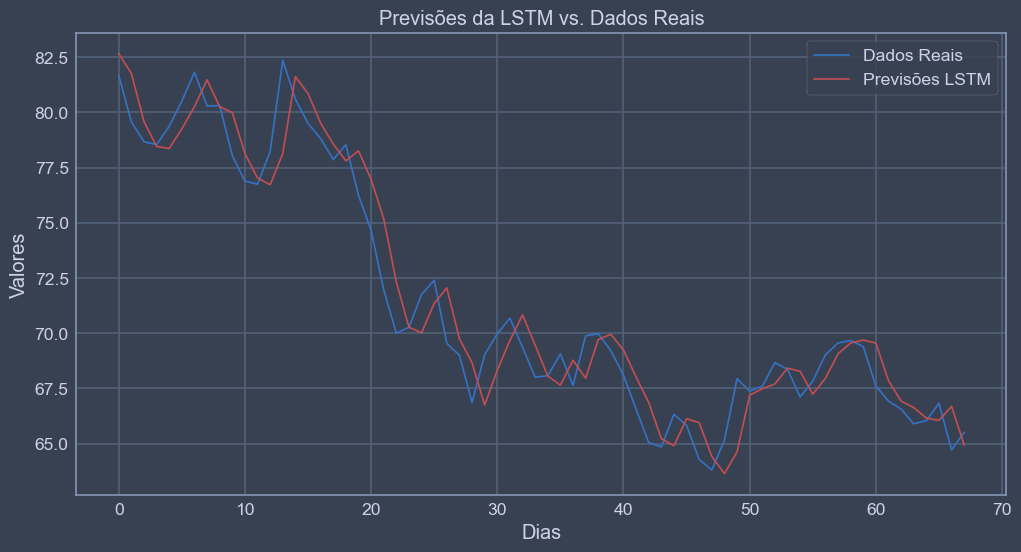

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Previsões usando o modelo LSTM
predictions_lstm = lstm_model.predict(x_test_lstm)

# Criando um vetor de índices para os dias
days = range(len(y_test))

plt.figure(figsize=(12, 6))
plt.plot(days, y_test, label='Dados Reais', color='b')
plt.plot(days, predictions_lstm, label='Previsões LSTM', color='r')
plt.xlabel('Dias')
plt.ylabel('Valores')
plt.title('Previsões da LSTM vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()


In [89]:
mse_test_lstm = MSE(y_test, y_pred_test_lstm)
mape_test_lstm = MAPE(y_test, y_pred_test_lstm) * 100

print('MSE (LSTM):', mse_test_lstm)
print('MAPE (LSTM):', mape_test_lstm)

MSE (LSTM): 2.7023417888623396
MAPE (LSTM): 1.7549970008812577


3/3 [==============================] - 0s 0s/step


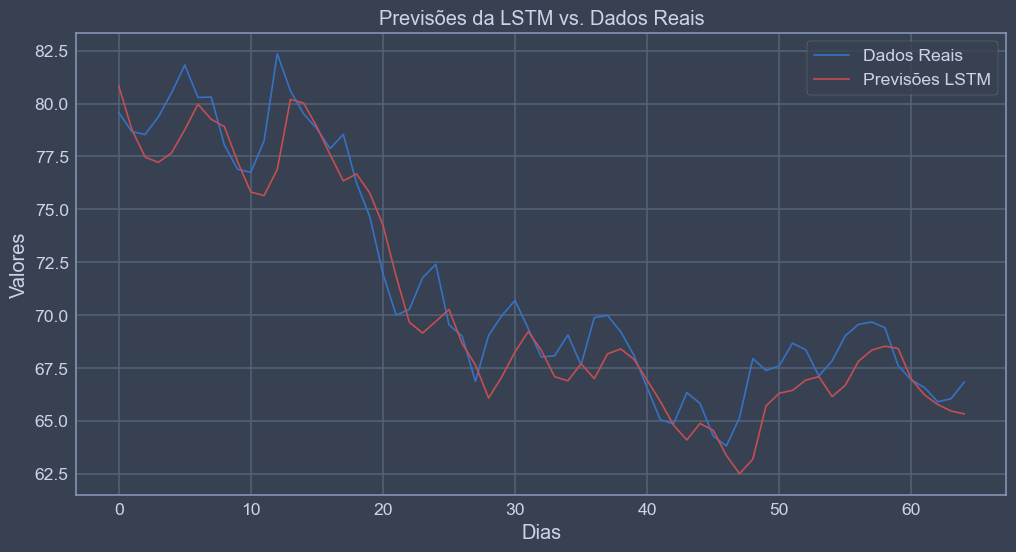

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Previsões usando o modelo LSTM
predictions_lstm = lstm_model.predict(x_test_lstm)

# Criando um vetor de índices para os dias
days = range(len(y_test))

plt.figure(figsize=(12, 6))
plt.plot(days, y_test, label='Dados Reais', color='b')
plt.plot(days, predictions_lstm, label='Previsões LSTM', color='r')
plt.xlabel('Dias')
plt.ylabel('Valores')
plt.title('Previsões da LSTM vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()


In [70]:
mse_test_lstm = MSE(y_test, y_pred_test_lstm)
mape_test_lstm = MAPE(y_test, y_pred_test_lstm) * 100

print('MSE (LSTM):', mse_test_lstm)
print('MAPE (LSTM):', mape_test_lstm)

MSE (LSTM): 3.1134199756891645
MAPE (LSTM): 1.870886607130141


### Hybrid Model

In [63]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data = df_vale['VALE3'].values

sequence_length = 5
sequences = []
targets = []

for i in range(len(data) - sequence_length):
    sequences.append(data[i:i+sequence_length])
    targets.append(data[i+sequence_length])

# Convertendo para arrays NumPy
sequences = np.array(sequences)
targets = np.array(targets)

# Dividindo os dados em conjuntos de treinamento, validação e teste
split_train = int(0.7 * len(sequences)) 
split_val = int(0.95 * len(sequences))  

x_train = sequences[:split_train]
x_val = sequences[split_train:split_val]
x_test = sequences[split_val:]

y_train = targets[:split_train]
y_val = targets[split_train:split_val]
y_test = targets[split_val:]

In [64]:
print(x_train.shape), print(x_val.shape), print(x_test.shape)


#(949, 5)
#(340, 5)
#(68, 5)

(949, 5)
(393, 5)
(15, 5)


(None, None, None)

In [65]:
# Criando o modelo MLP
mlp_model = keras.Sequential([
    layers.Flatten(input_shape=(sequence_length, 1)),
    layers.Dense(100, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(1)
])

# Criando o modelo LSTM
lstm_model = keras.Sequential([
    layers.LSTM(100, input_shape=(sequence_length, 1), return_sequences=True),
    layers.LSTM(50),
    layers.Dense(1)
])

# Combinando os modelos MLP e LSTM
combined_input = layers.Input(shape=(sequence_length, 1))
mlp_output = mlp_model(combined_input)
lstm_output = lstm_model(combined_input)
combined_output = layers.Average()([mlp_output, lstm_output])

model = keras.Model(inputs=combined_input, outputs=combined_output)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=1000, batch_size=32, validation_data=(x_val, y_val))

loss = model.evaluate(x_test, y_test)
print(f"Loss no conjunto de teste: {loss:.4f}")

predictions_lstm = model.predict(x_test)

Epoch 1/1000
30/30 [==============================] - 5s 43ms/step - loss: 851.9608 - val_loss: 92.8893
Epoch 2/1000
30/30 [==============================] - 0s 12ms/step - loss: 24.3387 - val_loss: 14.4228
Epoch 3/1000
30/30 [==============================] - 0s 11ms/step - loss: 5.5679 - val_loss: 7.9034
Epoch 4/1000
30/30 [==============================] - 0s 13ms/step - loss: 5.0739 - val_loss: 7.7464
Epoch 5/1000
30/30 [==============================] - 0s 14ms/step - loss: 4.9376 - val_loss: 8.0326
Epoch 6/1000
30/30 [==============================] - 1s 22ms/step - loss: 4.7929 - val_loss: 7.7266
Epoch 7/1000
30/30 [==============================] - 1s 22ms/step - loss: 4.6851 - val_loss: 7.7822
Epoch 8/1000
30/30 [==============================] - 1s 21ms/step - loss: 4.5249 - val_loss: 7.7008
Epoch 9/1000
30/30 [==============================] - 1s 21ms/step - loss: 4.5228 - val_loss: 7.8263
Epoch 10/1000
30/30 [==============================] - 1s 21ms/step - loss: 4.4735 - v

Epoch 161/1000
30/30 [==============================] - 1s 20ms/step - loss: 2.5464 - val_loss: 4.4897
Epoch 162/1000
30/30 [==============================] - 1s 19ms/step - loss: 3.0010 - val_loss: 3.8820
Epoch 163/1000
30/30 [==============================] - 1s 22ms/step - loss: 2.5031 - val_loss: 4.3664
Epoch 164/1000
30/30 [==============================] - 1s 22ms/step - loss: 2.8797 - val_loss: 5.5640
Epoch 165/1000
30/30 [==============================] - 1s 21ms/step - loss: 3.0542 - val_loss: 3.5852
Epoch 166/1000
30/30 [==============================] - 1s 21ms/step - loss: 2.6770 - val_loss: 3.9865
Epoch 167/1000
30/30 [==============================] - 1s 21ms/step - loss: 2.5066 - val_loss: 3.8025
Epoch 168/1000
30/30 [==============================] - 1s 21ms/step - loss: 2.4873 - val_loss: 3.8814
Epoch 169/1000
30/30 [==============================] - 1s 20ms/step - loss: 2.6928 - val_loss: 3.5965
Epoch 170/1000
30/30 [==============================] - 1s 18ms/step - lo

30/30 [==============================] - 1s 25ms/step - loss: 2.4156 - val_loss: 4.8757
Epoch 320/1000
30/30 [==============================] - 1s 24ms/step - loss: 2.5449 - val_loss: 3.6446
Epoch 321/1000
30/30 [==============================] - 1s 18ms/step - loss: 3.0028 - val_loss: 3.6149
Epoch 322/1000
30/30 [==============================] - 1s 26ms/step - loss: 2.4554 - val_loss: 3.9529
Epoch 323/1000
30/30 [==============================] - 1s 26ms/step - loss: 2.3592 - val_loss: 3.5369
Epoch 324/1000
30/30 [==============================] - 1s 23ms/step - loss: 2.4848 - val_loss: 4.4089
Epoch 325/1000
30/30 [==============================] - 1s 25ms/step - loss: 2.6857 - val_loss: 3.5831
Epoch 326/1000
30/30 [==============================] - 1s 25ms/step - loss: 2.6580 - val_loss: 5.5575
Epoch 327/1000
30/30 [==============================] - 1s 25ms/step - loss: 2.4678 - val_loss: 3.7355
Epoch 328/1000
30/30 [==============================] - 1s 25ms/step - loss: 2.7360 - va

30/30 [==============================] - 1s 24ms/step - loss: 2.2470 - val_loss: 3.6187
Epoch 478/1000
30/30 [==============================] - 1s 25ms/step - loss: 2.7663 - val_loss: 4.2953
Epoch 479/1000
30/30 [==============================] - 1s 24ms/step - loss: 2.8053 - val_loss: 4.8550
Epoch 480/1000
30/30 [==============================] - 1s 23ms/step - loss: 2.5111 - val_loss: 3.7016
Epoch 481/1000
30/30 [==============================] - 1s 24ms/step - loss: 2.4188 - val_loss: 3.8745
Epoch 482/1000
30/30 [==============================] - 0s 15ms/step - loss: 2.2075 - val_loss: 3.6508
Epoch 483/1000
30/30 [==============================] - 1s 17ms/step - loss: 2.2807 - val_loss: 3.8411
Epoch 484/1000
30/30 [==============================] - 0s 16ms/step - loss: 2.2042 - val_loss: 3.6503
Epoch 485/1000
30/30 [==============================] - 0s 16ms/step - loss: 2.3823 - val_loss: 4.3280
Epoch 486/1000
30/30 [==============================] - 0s 13ms/step - loss: 2.3517 - va

30/30 [==============================] - 1s 22ms/step - loss: 2.6889 - val_loss: 4.5221
Epoch 636/1000
30/30 [==============================] - 1s 22ms/step - loss: 2.1562 - val_loss: 3.8527
Epoch 637/1000
30/30 [==============================] - 1s 20ms/step - loss: 2.2589 - val_loss: 4.3223
Epoch 638/1000
30/30 [==============================] - 1s 19ms/step - loss: 2.3721 - val_loss: 4.0072
Epoch 639/1000
30/30 [==============================] - 1s 20ms/step - loss: 2.1643 - val_loss: 4.0629
Epoch 640/1000
30/30 [==============================] - 1s 21ms/step - loss: 2.1952 - val_loss: 4.2492
Epoch 641/1000
30/30 [==============================] - 1s 20ms/step - loss: 2.1229 - val_loss: 4.2471
Epoch 642/1000
30/30 [==============================] - 0s 14ms/step - loss: 2.1558 - val_loss: 3.9084
Epoch 643/1000
30/30 [==============================] - 0s 12ms/step - loss: 2.0977 - val_loss: 3.8426
Epoch 644/1000
30/30 [==============================] - 0s 12ms/step - loss: 2.3017 - va

30/30 [==============================] - 1s 25ms/step - loss: 2.1102 - val_loss: 4.4145
Epoch 794/1000
30/30 [==============================] - 1s 19ms/step - loss: 2.3689 - val_loss: 5.0550
Epoch 795/1000
30/30 [==============================] - 1s 17ms/step - loss: 2.8442 - val_loss: 4.2275
Epoch 796/1000
30/30 [==============================] - 0s 17ms/step - loss: 2.2472 - val_loss: 4.3103
Epoch 797/1000
30/30 [==============================] - 1s 21ms/step - loss: 2.1519 - val_loss: 5.7120
Epoch 798/1000
30/30 [==============================] - 1s 21ms/step - loss: 2.1933 - val_loss: 4.7235
Epoch 799/1000
30/30 [==============================] - 1s 20ms/step - loss: 2.1173 - val_loss: 4.1760
Epoch 800/1000
30/30 [==============================] - 1s 22ms/step - loss: 2.1202 - val_loss: 5.2748
Epoch 801/1000
30/30 [==============================] - 1s 18ms/step - loss: 2.0930 - val_loss: 4.7849
Epoch 802/1000
30/30 [==============================] - 0s 12ms/step - loss: 2.1529 - va

30/30 [==============================] - 1s 22ms/step - loss: 2.3084 - val_loss: 4.6050
Epoch 952/1000
30/30 [==============================] - 1s 22ms/step - loss: 2.0959 - val_loss: 5.5472
Epoch 953/1000
30/30 [==============================] - 1s 21ms/step - loss: 2.1649 - val_loss: 5.0238
Epoch 954/1000
30/30 [==============================] - 1s 17ms/step - loss: 2.3767 - val_loss: 4.7668
Epoch 955/1000
30/30 [==============================] - 0s 15ms/step - loss: 2.4061 - val_loss: 4.7009
Epoch 956/1000
30/30 [==============================] - 0s 13ms/step - loss: 2.3234 - val_loss: 4.9449
Epoch 957/1000
30/30 [==============================] - 0s 16ms/step - loss: 2.1352 - val_loss: 4.8659
Epoch 958/1000
30/30 [==============================] - 1s 22ms/step - loss: 2.2860 - val_loss: 4.5669
Epoch 959/1000
30/30 [==============================] - 1s 22ms/step - loss: 2.0970 - val_loss: 4.8377
Epoch 960/1000
30/30 [==============================] - 1s 21ms/step - loss: 2.1616 - va

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 

mse_test_hyb = mean_squared_error(y_test, predictions_lstm)  
print(f"Mean Squared Error (MSE): {mse_test_hyb:.1f}")  
def mean_absolute_percentage_error(y_true, y_pred):  
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  

# Deu 3.6  
# Mean Squared Error (MSE): 5.3  

Mean Squared Error (MSE): 4.1


In [242]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_test_hyb = mean_squared_error(y_test, predictions_lstm)
print(f"Mean Squared Error (MSE): {mse_test_hyb:.1f}")
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_hyb = mean_absolute_percentage_error(y_test, predictions_lstm)
print(f"Mean Absolute Percentage Error (MAPE): {mape_hyb:.1f}")

Mean Squared Error (MSE): 3.1
Mean Absolute Percentage Error (MAPE): 8.4


3/3 [==============================] - 0s 0s/step


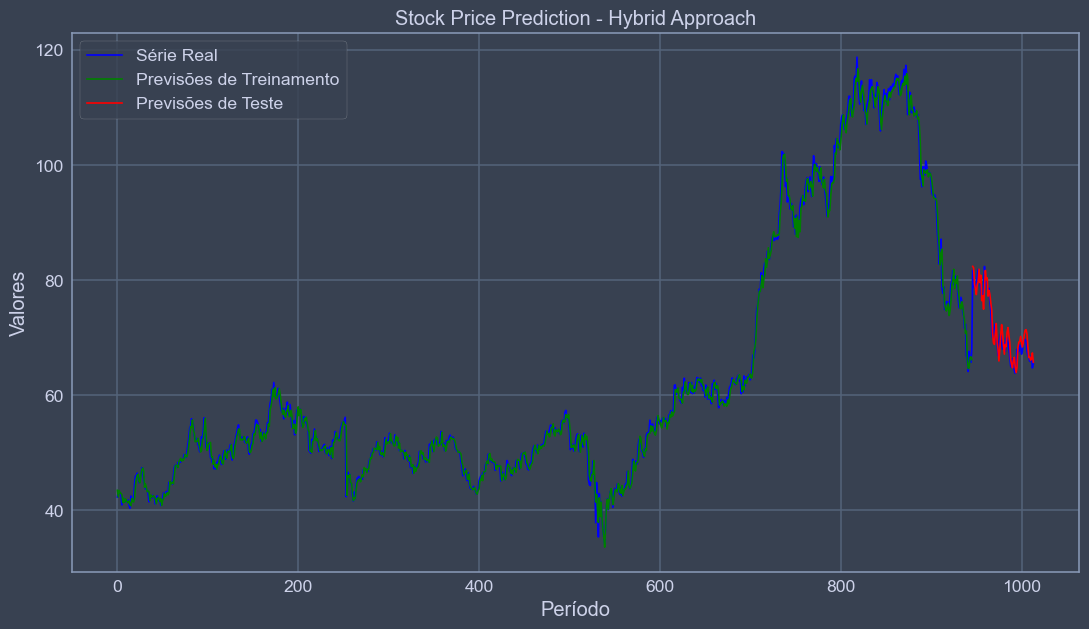

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 7))

real_data = np.concatenate([y_train, y_test])

train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

dates = np.arange(len(real_data))

plt.plot(dates, real_data, label='Série Real', color='blue')

plt.plot(dates[:len(train_predictions)], train_predictions, label='Previsões de Treinamento', color='green')
plt.plot(dates[len(train_predictions):], test_predictions, label='Previsões de Teste', color='red')

plt.xlabel('Período')
plt.ylabel('Valores')
plt.title('Stock Price Prediction - Hybrid Approach')

plt.legend()
plt.show()

### Hybrid with Hyperparameters

In [67]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data = df_vale['VALE3'].values
sequence_length = 5  # Aumentando o tamanho da sequência para 20

sequences = []
targets = []

for i in range(len(data) - sequence_length):
    sequences.append(data[i:i + sequence_length])
    targets.append(data[i + sequence_length])

sequences = np.array(sequences)
targets = np.array(targets)

split_train = int(0.7 * len(sequences))
split_val = int(0.989 * len(sequences)) 

x_train = sequences[:split_train]
x_val = sequences[split_train:split_val]
x_test = sequences[split_val:]

y_train = targets[:split_train]
y_val = targets[split_train:split_val]
y_test = targets[split_val:]

# Criando o modelo MLP com mais camadas Dense e Dropout
mlp_model = keras.Sequential([
    layers.Flatten(input_shape=(sequence_length, 1)),
    layers.Dense(250, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(1)
])

# Criando o modelo LSTM com mais camadas LSTM e Dropout
lstm_model = keras.Sequential([
    layers.LSTM(250, return_sequences=True, activation='relu', input_shape=(sequence_length, 1)),
    layers.LSTM(200, return_sequences=True, activation='relu', input_shape=(sequence_length, 1)),
    layers.LSTM(150, return_sequences=True, activation='relu', input_shape=(sequence_length, 1)),    
    layers.LSTM(100, return_sequences=True, activation='relu'),
    layers.LSTM(50, activation='relu'),
    layers.Dense(1)
])

combined_input = layers.Input(shape=(sequence_length, 1))
mlp_output = mlp_model(combined_input)
lstm_output = lstm_model(combined_input)
combined_output = layers.Average()([mlp_output, lstm_output])

model_hybrid_hyper = keras.Model(inputs=combined_input, outputs=combined_output)

model_hybrid_hyper.compile(optimizer='adam', loss='mean_squared_error')

model_hybrid_hyper.fit(x_train, y_train, epochs=1000, batch_size=32, validation_data=(x_val, y_val))

loss = model_hybrid_hyper.evaluate(x_test, y_test)
print(f"Loss no conjunto de teste: {loss:.4f}")

predictions_hyb_hyper = model_hybrid_hyper.predict(x_test)

Epoch 1/1000
30/30 [==============================] - 9s 77ms/step - loss: 796.9142 - val_loss: 9.9306
Epoch 2/1000
30/30 [==============================] - 1s 44ms/step - loss: 7.1863 - val_loss: 8.1326
Epoch 3/1000
30/30 [==============================] - 1s 47ms/step - loss: 4.9856 - val_loss: 7.9489
Epoch 4/1000
30/30 [==============================] - 1s 46ms/step - loss: 4.6880 - val_loss: 8.5311
Epoch 5/1000
30/30 [==============================] - 1s 46ms/step - loss: 4.6434 - val_loss: 7.6467
Epoch 6/1000
30/30 [==============================] - 1s 43ms/step - loss: 4.6977 - val_loss: 7.2229
Epoch 7/1000
30/30 [==============================] - 2s 73ms/step - loss: 4.0502 - val_loss: 6.6552
Epoch 8/1000
30/30 [==============================] - 2s 78ms/step - loss: 3.9866 - val_loss: 6.2734
Epoch 9/1000
30/30 [==============================] - 2s 76ms/step - loss: 4.2058 - val_loss: 5.9839
Epoch 10/1000
30/30 [==============================] - 2s 77ms/step - loss: 3.6997 - val_

Epoch 161/1000
30/30 [==============================] - 2s 68ms/step - loss: 3.0514 - val_loss: 14.9866
Epoch 162/1000
30/30 [==============================] - 2s 60ms/step - loss: 4.1588 - val_loss: 4.0866
Epoch 163/1000
30/30 [==============================] - 2s 62ms/step - loss: 2.6208 - val_loss: 3.8689
Epoch 164/1000
30/30 [==============================] - 2s 62ms/step - loss: 3.1181 - val_loss: 3.5917
Epoch 165/1000
30/30 [==============================] - 2s 72ms/step - loss: 3.7234 - val_loss: 5.3911
Epoch 166/1000
30/30 [==============================] - 2s 64ms/step - loss: 3.0615 - val_loss: 6.6652
Epoch 167/1000
30/30 [==============================] - 2s 70ms/step - loss: 5.0059 - val_loss: 6.5959
Epoch 168/1000
30/30 [==============================] - 2s 61ms/step - loss: 3.7615 - val_loss: 3.9448
Epoch 169/1000
30/30 [==============================] - 2s 65ms/step - loss: 2.8682 - val_loss: 4.9649
Epoch 170/1000
30/30 [==============================] - 2s 66ms/step - l

30/30 [==============================] - 2s 59ms/step - loss: 2.6134 - val_loss: 3.4656
Epoch 320/1000
30/30 [==============================] - 2s 60ms/step - loss: 2.8590 - val_loss: 5.6200
Epoch 321/1000
30/30 [==============================] - 2s 67ms/step - loss: 4.3144 - val_loss: 8.2623
Epoch 322/1000
30/30 [==============================] - 2s 68ms/step - loss: 3.7302 - val_loss: 3.6697
Epoch 323/1000
30/30 [==============================] - 2s 69ms/step - loss: 2.5809 - val_loss: 3.4933
Epoch 324/1000
30/30 [==============================] - 2s 63ms/step - loss: 2.9929 - val_loss: 3.8867
Epoch 325/1000
30/30 [==============================] - 2s 59ms/step - loss: 2.9861 - val_loss: 3.4835
Epoch 326/1000
30/30 [==============================] - 2s 59ms/step - loss: 3.1889 - val_loss: 4.2590
Epoch 327/1000
30/30 [==============================] - 2s 55ms/step - loss: 2.8422 - val_loss: 3.8358
Epoch 328/1000
30/30 [==============================] - 2s 61ms/step - loss: 2.6410 - va

30/30 [==============================] - 2s 67ms/step - loss: 2.8804 - val_loss: 6.1620
Epoch 478/1000
30/30 [==============================] - 2s 60ms/step - loss: 2.9213 - val_loss: 3.6336
Epoch 479/1000
30/30 [==============================] - 2s 58ms/step - loss: 2.7034 - val_loss: 3.6670
Epoch 480/1000
30/30 [==============================] - 2s 62ms/step - loss: 2.8975 - val_loss: 3.7904
Epoch 481/1000
30/30 [==============================] - 2s 67ms/step - loss: 2.8978 - val_loss: 3.5280
Epoch 482/1000
30/30 [==============================] - 2s 69ms/step - loss: 2.5471 - val_loss: 3.7158
Epoch 483/1000
30/30 [==============================] - 2s 73ms/step - loss: 2.6209 - val_loss: 5.7918
Epoch 484/1000
30/30 [==============================] - 2s 64ms/step - loss: 3.3127 - val_loss: 3.4528
Epoch 485/1000
30/30 [==============================] - 2s 60ms/step - loss: 3.3745 - val_loss: 3.5699
Epoch 486/1000
30/30 [==============================] - 2s 58ms/step - loss: 2.9765 - va

30/30 [==============================] - 2s 60ms/step - loss: 2.9131 - val_loss: 3.4978
Epoch 636/1000
30/30 [==============================] - 2s 65ms/step - loss: 2.6305 - val_loss: 3.5703
Epoch 637/1000
30/30 [==============================] - 2s 68ms/step - loss: 2.6452 - val_loss: 4.7896
Epoch 638/1000
30/30 [==============================] - 2s 67ms/step - loss: 2.8154 - val_loss: 3.4222
Epoch 639/1000
30/30 [==============================] - 2s 64ms/step - loss: 3.2775 - val_loss: 5.5980
Epoch 640/1000
30/30 [==============================] - 2s 57ms/step - loss: 2.8876 - val_loss: 3.5914
Epoch 641/1000
30/30 [==============================] - 2s 58ms/step - loss: 2.5008 - val_loss: 3.4351
Epoch 642/1000
30/30 [==============================] - 2s 56ms/step - loss: 2.6473 - val_loss: 3.6554
Epoch 643/1000
30/30 [==============================] - 2s 70ms/step - loss: 2.6889 - val_loss: 3.5276
Epoch 644/1000
30/30 [==============================] - 2s 62ms/step - loss: 2.6478 - va

30/30 [==============================] - 2s 59ms/step - loss: 3.2154 - val_loss: 3.9129
Epoch 794/1000
30/30 [==============================] - 2s 65ms/step - loss: 2.9411 - val_loss: 4.0558
Epoch 795/1000
30/30 [==============================] - 2s 67ms/step - loss: 2.9160 - val_loss: 4.2921
Epoch 796/1000
30/30 [==============================] - 2s 70ms/step - loss: 2.8060 - val_loss: 4.7297
Epoch 797/1000
30/30 [==============================] - 2s 65ms/step - loss: 2.6778 - val_loss: 5.0839
Epoch 798/1000
30/30 [==============================] - 2s 59ms/step - loss: 3.0825 - val_loss: 3.5404
Epoch 799/1000
30/30 [==============================] - 2s 57ms/step - loss: 2.5318 - val_loss: 3.4687
Epoch 800/1000
30/30 [==============================] - 2s 57ms/step - loss: 2.7544 - val_loss: 3.4426
Epoch 801/1000
30/30 [==============================] - 2s 58ms/step - loss: 3.8108 - val_loss: 3.8044
Epoch 802/1000
30/30 [==============================] - 2s 63ms/step - loss: 2.5740 - va

30/30 [==============================] - 2s 58ms/step - loss: 2.3475 - val_loss: 3.4221
Epoch 952/1000
30/30 [==============================] - 2s 56ms/step - loss: 2.4889 - val_loss: 4.2773
Epoch 953/1000
30/30 [==============================] - 2s 83ms/step - loss: 2.5823 - val_loss: 3.5317
Epoch 954/1000
30/30 [==============================] - 2s 72ms/step - loss: 2.6711 - val_loss: 3.6041
Epoch 955/1000
30/30 [==============================] - 2s 69ms/step - loss: 2.3205 - val_loss: 3.7016
Epoch 956/1000
30/30 [==============================] - 2s 69ms/step - loss: 2.5480 - val_loss: 3.4197
Epoch 957/1000
30/30 [==============================] - 2s 66ms/step - loss: 2.3902 - val_loss: 3.5887
Epoch 958/1000
30/30 [==============================] - 2s 56ms/step - loss: 3.2780 - val_loss: 3.5874
Epoch 959/1000
30/30 [==============================] - 2s 59ms/step - loss: 3.1239 - val_loss: 3.7702
Epoch 960/1000
30/30 [==============================] - 2s 59ms/step - loss: 2.9944 - va

In [241]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, predictions_hyb_hyper)
print(f'Mean Squared Error (MSE): {mse:.1f}')
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, predictions_hyb_hyper)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.1f}')

Mean Squared Error (MSE): 2.2
Mean Absolute Percentage Error (MAPE): 8.4


In [73]:
print(x_train.shape), print(x_test.shape), print(x_val.shape)

(949, 5)
(15, 5)
(393, 5)


(None, None, None)

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 7))

real_data = np.concatenate([y_train, y_test])

train_predictions_hyb_param = model_hybrid_hyper.predict(x_train)
test_predictions_hyb_param = model_hybrid_hyper.predict(x_test)

dates = np.arange(len(real_data))

1/1 [==============================] - 0s 51ms/step


<Figure size 1300x700 with 0 Axes>

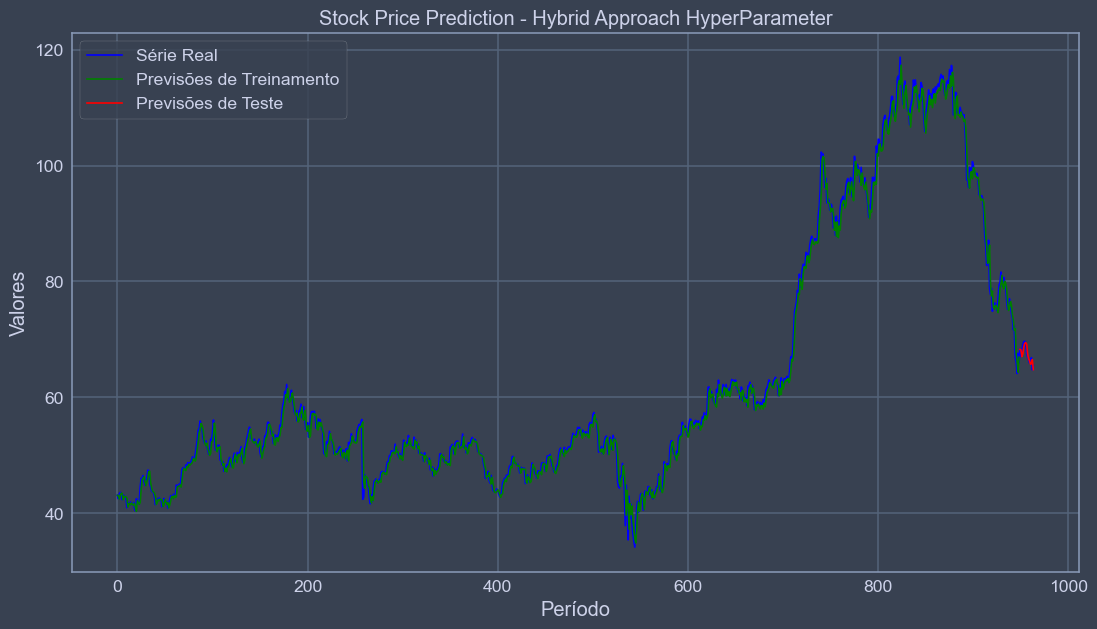

In [75]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 7))

dates = np.arange(len(real_data))

plt.plot(dates, real_data, label='Série Real', color='blue')

plt.plot(dates[:len(train_predictions_hyb_param)], train_predictions_hyb_param, label='Previsões de Treinamento', color='green')
plt.plot(dates[len(train_predictions_hyb_param):], test_predictions_hyb_param, label='Previsões de Teste', color='red')

plt.xlabel('Período')
plt.ylabel('Valores')
plt.title('Stock Price Prediction - Hybrid Approach HyperParameter')

plt.legend()
plt.show()

In [134]:
num_days_to_predict = 10

current_sequences = x_test[-2:]  # Incluindo as duas últimas sequências

predictions_backtest = []

for i in range(num_days_to_predict):
    next_day_prediction = model_hybrid_hyper.predict([current_sequences])[0][0]
    predictions_backtest.append(next_day_prediction)

    for j in range(2):
        current_sequences[j] = np.roll(current_sequences[j], shift=-1)
        current_sequences[j][-1] = next_day_prediction

print(predictions_backtest)

1/1 [==============================] - 0s 17ms/step
[60.94569, 60.665913, 60.37709, 60.078365, 59.768967, 59.449757, 59.119965, 58.77935, 58.42736, 58.0637]


In [136]:
current_sequences

array([[59.44975662, 59.1199646 , 58.77935028, 58.42736053, 58.06370163],
       [59.44975662, 59.1199646 , 58.77935028, 58.42736053, 58.06370163]])

In [137]:
predictions_backtest, print(len(predictions_backtest))

10


([60.94569,
  60.665913,
  60.37709,
  60.078365,
  59.768967,
  59.449757,
  59.119965,
  58.77935,
  58.42736,
  58.0637],
 None)

In [138]:
len(current_sequences)

2

In [139]:
x_test[-2]

array([59.44975662, 59.1199646 , 58.77935028, 58.42736053, 58.06370163])

### Dados Backteste (15 pasos)

In [140]:
ticker_symbols = ['VALE3.SA'] 
start_date_backteste = '2023-07-01' 
end_date_backteste = '2023-07-15' 
df_vale_backteste = yf.download(ticker_symbols, start=start_date_backteste, end=end_date_backteste)

# Mentando apenas a coluna 'Close' e renomeie-a para 'BOVA11'
df_vale_backteste = df_vale_backteste[['Close']].rename(columns={'Close': 'VALE3'})
df_vale_backteste.shape

[*********************100%%**********************]  1 of 1 completed


(10, 1)

In [141]:
df_vale_backteste

,VALE3
Date,
2023-07-03,66.230003
2023-07-04,65.900002
2023-07-05,65.320000
2023-07-06,64.849998
2023-07-07,65.459999
2023-07-10,64.459999
2023-07-11,66.580002
2023-07-12,67.050003
2023-07-13,68.610001


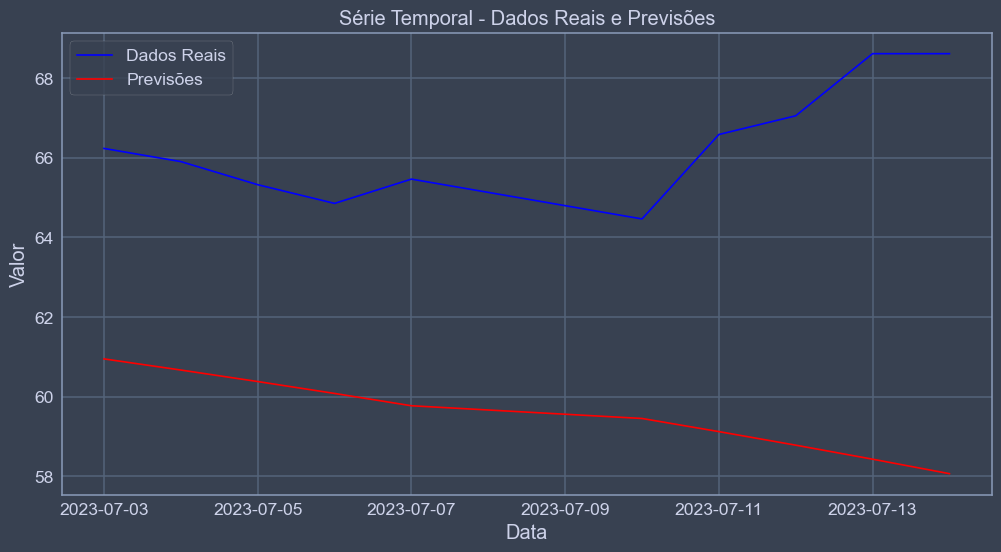

In [142]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import BDay

data_inicial = pd.to_datetime('2023-07-03')
dias_uteis_avancar = 10 - 1 

data_final = data_inicial + pd.tseries.offsets.BDay(dias_uteis_avancar)

dates_real = pd.date_range(start=data_inicial, end=data_final, freq='B')

predictions_backtest = predictions_backtest[:len(dates_real)]

df_vale_backteste = df_vale_backteste[:len(dates_real)]

plt.figure(figsize=(12, 6))
plt.plot(dates_real, df_vale_backteste, label='Dados Reais', color='blue')

plt.plot(dates_real, predictions_backtest, label='Previsões', color='red')

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal - Dados Reais e Previsões')
plt.legend()
plt.grid(True)
plt.show()

Conclusão: <br>
Ainda conseguindo um bom resultado MSE no modelo com os dados de teste, ele não parece estar fazendo uma boa previsão ante as mudanças de conceito no comportamento real dos dados, mas sim parece estar seguindo a tendencia introducida pela última sequencia (últimos 20 dias considerados) e a partir daí identificando as previsões como tendencia negativa.

Próximos Passos: <br>
Resultaria muito interessante considerar algumas outras características, próprias de mudança de conceito, como o caso de cenários de risco sistemático.

# Aplicando Algoritmo Genetico para Otimização

In [35]:
!pip install deap

  Using cached deap-1.4.1-cp310-cp310-win_amd64.whl.metadata (13 kB)
Using cached deap-1.4.1-cp310-cp310-win_amd64.whl (109 kB)


In [70]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from deap import base, creator, tools, algorithms

data = df_vale['VALE3'].values
sequence_length = 5  # Aumentando o tamanho da sequência para 20

sequences = []
targets = []

for i in range(len(data) - sequence_length):
    sequences.append(data[i:i + sequence_length])
    targets.append(data[i + sequence_length])

sequences = np.array(sequences)
targets = np.array(targets)

split_train = int(0.7 * len(sequences))
split_val = int(0.989 * len(sequences)) 

x_train = sequences[:split_train]
x_val = sequences[split_train:split_val]
x_test = sequences[split_val:]

y_train = targets[:split_train]
y_val = targets[split_train:split_val]
y_test = targets[split_val:]

# Função de Avaliação para o GA
def evaluate_individual(individual):
    mlp_layers = individual[:3]
    lstm_layers = individual[3:]

    mlp_model = keras.Sequential([
        layers.Flatten(input_shape=(sequence_length, 1)),
        layers.Dense(mlp_layers[0], activation='relu'),
        layers.Dense(mlp_layers[1], activation='relu'),
        layers.Dense(mlp_layers[2], activation='relu'),
        layers.Dense(1)
    ])

    lstm_model = keras.Sequential([
        layers.LSTM(units, return_sequences=True, activation='relu', input_shape=(sequence_length, 1))
        for units in lstm_layers[:-1]
    ] + [layers.LSTM(lstm_layers[-1], activation='relu'), layers.Dense(1)])

    combined_input = layers.Input(shape=(sequence_length, 1))
    mlp_output = mlp_model(combined_input)
    lstm_output = lstm_model(combined_input)
    combined_output = layers.Average()([mlp_output, lstm_output])

    model = keras.Model(inputs=combined_input, outputs=combined_output)
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), verbose=0)

    loss = model.evaluate(x_val, y_val, verbose=0)

    return loss,

# Configuração do GA
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_int", np.random.randint, 50, 300)  # Número de unidades para cada camada
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=6)  # 3 camadas MLP e 3 camadas LSTM
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=50, up=300, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_individual)

# Executar o GA
population = toolbox.population(n=10)
algorithms.eaMuPlusLambda(population, toolbox, mu=10, lambda_=20, cxpb=0.7, mutpb=0.2, ngen=5, stats=None, halloffame=None, verbose=True)

# Obter o melhor indivíduo
best_individual = tools.selBest(population, k=1)[0]
best_mlp_layers = best_individual[:3]
best_lstm_layers = best_individual[3:]

# Use os melhores hiperparâmetros para criar o modelo final
best_mlp_model = keras.Sequential([
    layers.Flatten(input_shape=(sequence_length, 1)),
    layers.Dense(best_mlp_layers[0], activation='relu'),
    layers.Dense(best_mlp_layers[1], activation='relu'),
    layers.Dense(best_mlp_layers[2], activation='relu'),
    layers.Dense(1)
])

best_lstm_model = keras.Sequential([
    layers.LSTM(units, return_sequences=True, activation='relu', input_shape=(sequence_length, 1))
    for units in best_lstm_layers[:-1]
] + [layers.LSTM(best_lstm_layers[-1], activation='relu'), layers.Dense(1)])

combined_input = layers.Input(shape=(sequence_length, 1))
best_mlp_output = best_mlp_model(combined_input)
best_lstm_output = best_lstm_model(combined_input)
combined_output = layers.Average()([best_mlp_output, best_lstm_output])

best_model = keras.Model(inputs=combined_input, outputs=combined_output)
best_model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo final com os melhores hiperparâmetros
best_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), verbose=1)

# Avaliar o modelo final
loss = best_model.evaluate(x_test, y_test)
print(f"Loss no conjunto de teste com melhores hiperparâmetros: {loss:.4f}")
 

gen	nevals
0  	10    
1  	18    
2  	17    
3  	18    
4  	19    
5  	15    
Epoch 1/100
30/30 [==============================] - 8s 76ms/step - loss: 688.0716 - val_loss: 36.0736
Epoch 2/100
30/30 [==============================] - 2s 53ms/step - loss: 8.1091 - val_loss: 8.5034
Epoch 3/100
30/30 [==============================] - 2s 63ms/step - loss: 4.3950 - val_loss: 7.4277
Epoch 4/100
30/30 [==============================] - 3s 97ms/step - loss: 4.3565 - val_loss: 7.3662
Epoch 5/100
30/30 [==============================] - 2s 61ms/step - loss: 4.3184 - val_loss: 7.1108
Epoch 6/100
30/30 [==============================] - 1s 44ms/step - loss: 4.0769 - val_loss: 7.0602
Epoch 7/100
30/30 [==============================] - 1s 41ms/step - loss: 4.1630 - val_loss: 7.1607
Epoch 8/100
30/30 [==============================] - 2s 62ms/step - loss: 4.1922 - val_loss: 7.6922
Epoch 9/100
30/30 [==============================] - 2s 66ms/step - loss: 4.0866 - val_loss: 6.8505
Epoch 10/100
30/30 [

<br>
Conseguimos um MSE = 1.2, considerando o modelo com 100 epocas, só pelo custo de processamento do GA. <br>
Mas devemos mencionar que considerando 1000 epocas o modelo obteve um MSE= 0.70